# Generate All Tables and Figures from this Evaluation

### All imported packages needed for each part of this computational experiment

In [1]:
import os
import sqlite3
import json
import requests
import re
import matplotlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from glob import glob

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 25}
matplotlib.rc('font', **font)

%matplotlib inline

### Functions used during analysis 

These function are used through out this analysis for various figures and tables.

In [2]:
# This function is used to take the processed filename-friendly version of
# a dataset's DOI and return the original DOI
def get_doi_from_filename(filename):
    filename = filename[2:len(filename)]
    doi = os.path.split(filename)[0]
    doi = doi.replace("-", ":", 1)
    doi = doi.replace("-", "/")
    return(doi)

def get_doi_from_tag_name(image_tag):
    return(image_tag[14:17] + image_tag[17:len(image_tag)].replace("-", ":", 1).upper().replace("-", "/"))


def get_doi_from_dir_path(dir_path):
    doi = dir_path.split("datasets/")[1]
    doi = doi.replace("-", ":", 1)
    doi = doi.replace("-", "/")
    return(doi)

# This function categorizes error messages by searching for the most unique and common phrases in different types of R error messages
def determine_error_cause(error_msg):
    ret_val = "other"
    
    if("Error in setwd" in error_msg):
        ret_val = "working directory"
    elif("Error in library" in error_msg):
        ret_val = "library"
    elif("Error in file" in error_msg):
        ret_val = "missing file"
    elif("unable to open" in error_msg):
        ret_val = "missing file"
    elif("Error in readChar" in error_msg):
        ret_val = "missing file"
    elif("could not find function" in error_msg):
        ret_val = "function"
    elif("there is no package called" in error_msg):
        ret_val = "library"
    elif("cannot open the connection" in error_msg):
        ret_val = "missing file"
    return(ret_val)

# This function is used when viewing the results of this analysis in the notebook
def print_error_breakdown(error_type, error_dict, num_of_errors):
    print(error_type + " errors: " + str(error_dict[error_type]) + ", or " + str((error_dict[error_type] / num_of_errors) * 100) + "% of total errors")
    
# This function takes a report dictionary and then returns a dictionary with three elements:
# "Errors": The number of scripts in the dataset that ran and encountered an error
# "No Errors": The number of scripts in the dataset that ran and did NOT encounter an error
# "Container-Wide": A boolean indicating whether or not all scripts in the dataset ran WITHOUT errors
def check_errors(report):
    no_errors = True
    num_errorless = 0
    num_errored = 0
    error_causes = []
    
    for script in report["Individual Scripts"]:
        if(len(report["Individual Scripts"][script]["Errors"]) > 0):
            no_errors = False
            #print(report["Individual Scripts"][script]["Errors"])
            num_errored += 1
            error_cause = determine_error_cause(report["Individual Scripts"][script]["Errors"][0])
            error_causes.append((error_cause, os.path.basename(script), report["Individual Scripts"][script]["Errors"][0]))
        else:
            num_errorless += 1
            error_causes.append(("success", os.path.basename(script), "success"))
    return({"Errors": num_errored, "No Errors": num_errorless, "Container-Wide": no_errors, "Error Causes": error_causes})


"""Download doi to the destination directory
Parameters
----------
doi : string
      doi of the dataset to be downloaded
api_url : string
          URL of the dataverse API to download the dataset from
Returns
-------
tuple
First element is a list of subjects the dataset was for, second is the year published
"""
def get_dataset_metadata(doi, api_url="https://dataverse.harvard.edu/api/"):
    problem_set = set(["doi:10.7910/DVN/I6H7L5\n",
        "doi:10.7910/DVN/IBY3PN\n",
        "doi:10.7910/DVN/NEIYVD\n",
        "doi:10.7910/DVN/HVY5GR\n",
        "doi:10.7910/DVN/HVY5GR\n",
        "doi:10.7910/DVN/UPL4TT\n",
        "doi:10.7910/DVN/65XKJO\n",
        "doi:10.7910/DVN/VUHAXF\n",
        "doi:10.7910/DVN/0WAEAM\n",
        "doi:10.7910/DVN/PJOMF1\n"])
    # This data has to be hard-coded later. Not sure why, these always time out
    if doi in problem_set:
        print("Skipping problematic dataset")
        return (False,False,False)
    api_url = api_url.strip("/")
    subject = None
    year = None
    num_files = None
    timeout_duration = 7
    timeout_limit = 4
    attempts = 0
    while (attempts < timeout_limit):
        try:
            # query the dataverse API for all the files in a dataverse
            files = requests.get(api_url + "/datasets/:persistentId",
                             params={"persistentId": doi}, timeout = timeout_duration).json()["data"]
        except requests.exceptions.ReadTimeout as e:
            attempts += 1
            if(attempts == timeout_limit):
                print("Timed-out too many times. Check internet connection?")
                print(doi)
                return(False)
            else:    
                print("Timeout hit trying again")
                continue
        except Exception as e:
            print("Could not get dataset info from dataverse")
            print(e)
            with open("../data/metadata_problem.txt", "a") as meta_prob:
                meta_prob.write(doi + "\n")
            return (False, False, False)
        break
        
    
    year = files["publicationDate"][0:4]
    if("latestVersion" not in files):
        print(doi)
    else:
        for field in files["latestVersion"]["metadataBlocks"]["citation"]["fields"]:
            if(field["typeName"] == "subject"):
                subject = field["value"]

    return(subject, year)

# Given a dictionary that has broken down datasets and their errors by subject or year, return a dataframe 
def create_breakdown_df(thing_breakdown, name):
    for thing in thing_breakdown.keys():
        thing_breakdown[thing]["percent"] = str(round((thing_breakdown[thing]["errors"] / thing_breakdown[thing]["total"]) * 100, 1)) + "%"
    breakdown_df = pd.DataFrame(thing_breakdown).transpose()
    breakdown_df.index.name = name
    breakdown_df.reset_index(level=0, inplace=True)
    breakdown_df = breakdown_df[[name, "total", "errors", "percent"]]
    breakdown_df.columns = [name, "Total Files", "Total Error Files", "Error Rate (Rounded)"]
    return(breakdown_df)

# Used to replace the last instance of a string character 
# Pulled from https://www.tutorialspoint.com/How-to-replace-the-last-occurrence-of-an-expression-in-a-string-in-Python
# on March 24, 2021
def rreplace(s, old, new):
    return (s[::-1].replace(old[::-1],new[::-1], 1))[::-1]

# Given a dataframe, write its contents to the results directory 
def write_tex_from_df(filename, df, caption = None, label = None, index = False, na_rep = "NaN", escape = True):
    df_latex = df.to_latex(index= index, caption = caption, label = label, na_rep = na_rep, escape = escape)
    df_latex = df_latex.replace("\\\n", "\\ \hline\n")
    df_latex = df_latex.replace("\\ \hline\n", "\\\n", 1)
    df_latex = rreplace(df_latex, "\\ \hline\n", "\\\n")
    with open("../results/" + filename, "w") as outfile:
        outfile.write(df_latex)

def library_name_from_error(error_msg):
    expr = ""
    if("Error in library" in error_msg):
        expr = "library\s*\(\"?([^\"]*)\"?\)"
    elif("there is no package called"):
        expr = "\‘(.*?)\’"
        
    lib_re = re.compile(expr)
    ret_val = None
    try:
        ret_val = lib_re.search(error_msg).groups()[0]
    except:
        ret_val = re.split("\"|\'", error_msg)[1]
    not_packages = ["packages_needed[i]", "pkg", "x", "p", "lib", "package_name", "package"]
    if("," in ret_val and ret_val.split(",")[0] not in not_packages):
        ret_val = ret_val.split(",")[0]
    elif"," in ret_val and ret_val.split(",")[0] in not_packages:
        ret_val = "__UNDEFINED__"
    return(ret_val.replace(" ", ""))


## Code used to generate tables displaying results of executing scripts WITHOUT RaaS

### Data Collection

The collected data from the evaluation where we tried to execute R scripts without RaaS is stored in the database called 'results.db'

In [6]:
con = sqlite3.connect("../data/results.db")

errors_df = pd.read_sql_query("SELECT * FROM results", con) 

### Analysis 

This cell analyzes each error stored in the database and uses the previously defined determine_error_cause function to categorize each as either library, working directory, missing file, missing function, or other. It also calculates how many datasets were "clean," meaning all the scripts executed within it ran with no errors. In order to facilitate tracking change in errors in scripts between not using RaaS and using RaaS we also create the doi_library that stores information about each dataset with the doi as the key

In [7]:
no_raas_total_error_results ={"Errors" : 0, "No Errors": 0, "Clean Datasets": 0}
no_raas_error_breakdown = {"library": 0, "working directory": 0, "missing file": 0, "function":0, "other": 0}
doi_library = {}
error_library = {"library": {}, "working directory": {}, "missing file": {}, "function":{}, "other": {}}
broken_packages = {}
num_datasets = 0

last_doi = None
current_doi_clean = True
for index, row in errors_df.iterrows():
    doi = get_doi_from_filename(row["filename"])
    if(doi != last_doi):
        num_datasets += 1
        if(current_doi_clean == True):
            no_raas_total_error_results["Clean Datasets"] += 1
            if(last_doi is not None): doi_library[last_doi]["no_raas_clean"] = True
        current_doi_clean = True
    if(row["error"] == "success"):
        no_raas_total_error_results["No Errors"] += 1
        if(doi in doi_library):
            doi_library[doi]["no raas"][os.path.basename(row["filename"])] = "success"
        else:
            doi_library[doi] = {"no raas":{os.path.basename(row["filename"]):"success"}}
    else:
        no_raas_total_error_results["Errors"] += 1
        current_doi_clean = False
        error_cause = determine_error_cause(row["error"])
        no_raas_error_breakdown[error_cause] += 1
        if(doi in doi_library):
            doi_library[doi]["no raas"][os.path.basename(row["filename"])] = error_cause
        else:
            doi_library[doi] = {"no raas":{os.path.basename(row["filename"]):error_cause}}
        if(doi in error_library[error_cause]):
            error_library[error_cause][doi]["no raas"].append(os.path.basename(row["filename"]))
        else:
            error_library[error_cause][doi] = {"no raas":[os.path.basename(row["filename"])]}
        if(error_cause == "library"):
            broken_package = library_name_from_error(row["error"])
            if(broken_package in broken_packages):
                broken_packages[broken_package] += 1
            else:
                broken_packages[broken_package] = 1
        doi_library[doi]["no_raas_clean"] = False
        
    last_doi = doi
    
broken_packages.pop("__UNDEFINED__")


95

In [8]:
no_raas_times = pd.read_csv("../data/dataset_times.csv")

for index, row in no_raas_times.iterrows():
    doi = get_doi_from_dir_path(row["doi"])
    if(doi not in doi_library):
        #print(doi)
        continue
    doi_library[doi]["no_raas_time"] = row["time"]

### View Results

This cell prints the results of the evaluation performed checking for errors without RaaS.

The publication presents this information in a table generated below.

In [6]:
no_raas_total_num_of_scripts = no_raas_total_error_results["Errors"] + no_raas_total_error_results["No Errors"]
print("Out of " + str(no_raas_total_num_of_scripts) + " total scripts")
print("Scripts without errors: " + str(no_raas_total_error_results['No Errors']) + ", or " + str((no_raas_total_error_results['No Errors'] / no_raas_total_num_of_scripts) * 100) + "% of total scripts")
print("Scripts with errors: " + str(no_raas_total_error_results['Errors']) + ", or " + str((no_raas_total_error_results['Errors'] / no_raas_total_num_of_scripts) * 100) + "% of total scripts")
print("Number of clean datasets: " + str(no_raas_total_error_results["Clean Datasets"]) + " out of " + str(num_datasets))
print("##############################################################\n\n")
print("Error Breakdown: ")
print_error_breakdown("library", no_raas_error_breakdown, no_raas_total_error_results['Errors'])
print_error_breakdown("working directory", no_raas_error_breakdown, no_raas_total_error_results['Errors'])
print_error_breakdown("missing file",no_raas_error_breakdown, no_raas_total_error_results['Errors'])
print_error_breakdown("function",no_raas_error_breakdown, no_raas_total_error_results['Errors'])
print_error_breakdown("other",no_raas_error_breakdown, no_raas_total_error_results['Errors'])

Out of 10213 total scripts
Scripts without errors: 1035, or 10.134142759228434% of total scripts
Scripts with errors: 9178, or 89.86585724077156% of total scripts
Number of clean datasets: 62 out of 2608
##############################################################


Error Breakdown: 
library errors: 5526, or 60.20919590324689% of total errors
working directory errors: 1265, or 13.782959250381346% of total errors
missing file errors: 856, or 9.326650686424058% of total errors
function errors: 613, or 6.679015035955546% of total errors
other errors: 918, or 10.002179123992155% of total errors


### Generate latex table

This cell will take the results computed previously and write the latex table used in the publication

In [7]:
# Generate overview of error occurence
error_occurrences_df = pd.DataFrame({"Result" : ["Success", "Error", "Total"],\
                                     "containR Count": ["408", "2431", "2839"],
                                    "RaaS Count": [str(no_raas_total_error_results['No Errors']), str(no_raas_total_error_results['Errors']),\
                                              str(no_raas_total_error_results['Errors'] + no_raas_total_error_results['No Errors'])],
                                    "containR %": ["14.4%", "85.6%", ""],
                                    "RaaS %": [str(round((no_raas_total_error_results['No Errors'] / no_raas_total_num_of_scripts) * 100, 1)) + "%", 
                                                            str(round((no_raas_total_error_results['Errors'] / no_raas_total_num_of_scripts) * 100, 1)) + "%", ""]})

write_tex_from_df("error_occurrences.tex", error_occurrences_df, \
                  label="tab:error-occurrences", \
                  caption = "The occurrences of errors in scripts from Dataverse without processing through RaaS. The percents are rounded to the nearest tenth.")

# Generate breakdown of most common errors
no_raas_error_data = []
for error_type in no_raas_error_breakdown.keys():
    no_raas_error_data.append({
        "Error Type": error_type.capitalize(), 
        "RaaS Count": str(no_raas_error_breakdown[error_type]), 
        "RaaS %": str(round((no_raas_error_breakdown[error_type] / no_raas_total_error_results['Errors']) * 100, 1)) + "%",
    })
    
no_raas_error_data.append({
    "Error Type": "Total", 
    "RaaS Count": no_raas_total_error_results['Errors'], 
    "RaaS %": "",
})
no_raas_error_data_df = pd.DataFrame(no_raas_error_data, columns=["Error Type", "RaaS Count", "RaaS %"])

no_raas_error_data_df["containR Count"] = ["363", "696", "802", "NA", "569", "2431"]
no_raas_error_data_df["containR %"] = ["14.9%", "28.6%", "33.0%", "NA", "23.4%", " "]

no_raas_error_data_df = no_raas_error_data_df[["Error Type", "containR Count", "RaaS Count", "containR %", "RaaS %"]]

write_tex_from_df("no_raas_error_data.tex", no_raas_error_data_df, \
                  label = "tab:error-causes", \
                  caption ="The most common causes of errors in scripts from Dataverse without processing through RaaS. The percents are rounded to the nearest tenth.")



### Breakdown datasets by year and subject

This section requires extra information that needs to be scraped from Harvard's Dataverse. We scraped this data on March 22, 2021 and saved it in the ../data/doi_metadata.json file. To re-scrape the data, uncomment out the lines in the multi-line comment, denoted by ' ' '. Then comment out the line at the bottom of the cell that reads the existing scraped data from the json file. 

In [8]:
doi_metadata = {}

'''
with open("../data/r_dois.txt", "r") as doi_file:
    doi_list = doi_file.readlines()

# The following dois data were manually added because we could not
# use the api to automatically scrape them
# doi:10.7910/DVN/I6H7L5 305
# doi:10.7910/DVN/IBY3PN 350
# doi:10.7910/DVN/NEIYVD 799
# doi:10.7910/DVN/HVY5GR 845
# doi:10.7910/DVN/HVY5GR 975
# doi:10.7910/DVN/UPL4TT 1355
# doi:10.7910/DVN/65XKJO 1356

with open("../data/metadata_problem.txt", "w") as meta_prob:
    meta_prob.write("List of dois\n")
    


total_dois = len(doi_list)
counter = 0
for doi in doi_list[2730:]:
    if(counter % 10 == 0):
        print(str(counter) + " of " + str(total_dois) + " datasets")
    subjects, year = get_dataset_metadata(doi)
    if(subjects is not False and doi not in doi_metadata):
        doi_metadata[doi] = (subjects, year)
    else:
        print("skipped")
    counter += 1



with open("../data/doi_metadata.json", "w") as doi_file:
    doi_file.write(json.dumps(doi_metadata))
'''
with open("../data/doi_metadata.json", "r") as doi_file:
    doi_metadata = json.loads(doi_file.read())


This next cell takes the doi metadata and groups errors by year and subject. The results will be the two dictionaries year_breakdown and subject_breakdown that contain the data that will be turned into a dataframe for export. 

In [9]:
year_breakdown = {}
subject_breakdown = {}

for doi in list(doi_library.keys()):
    if(doi not in doi_metadata):
        print(doi)
        continue
    subjects = doi_metadata[doi][0]
    year = doi_metadata[doi][1]
    # Breakdown dataset by year
    if(year not in year_breakdown):
        year_breakdown[year] = {"errors": 0, "total" : 0}
    for value in doi_library[doi]["no raas"].values():
        if (value != "success"):
            year_breakdown[year]["errors"] += 1
    year_breakdown[year]["total"] += len(doi_library[doi]["no raas"].values())
    if(subjects is None):
        #print(doi + " has no subjects")
        continue
    # Breakdown dataset by subject
    for subject in subjects:
        if(subject not in subject_breakdown):
            subject_breakdown[subject] = {"errors": 0, "total" : 0}
        for value in doi_library[doi]["no raas"].values():
            if (value != "success"):
                subject_breakdown[subject]["errors"] += 1
        subject_breakdown[subject]["total"] += len(doi_library[doi]["no raas"].values())

doi:10.7910/DVN/C2QO6J
doi:10.7910/DVN/AIPWNU
doi:10.7910/DVN/SUN4KZ
doi:10.7910/DVN/3BSCKY
doi:10.7910/DVN/EE7UJZ
doi:10.7910/DVN/XI7ENB


Convert the dictionaries into dataframes and write the resulting tables to the filesystem in latex format

In [10]:
year_breakdown_df = create_breakdown_df(year_breakdown, "Year")
year_breakdown_df.sort_values(["Year"], inplace=True)


subject_breakdown_df = create_breakdown_df(subject_breakdown, "Subject")
subject_breakdown_df['Subject'] = pd.Categorical(subject_breakdown_df['Subject'],categories=['Social Sciences',\
                                                           'Computer and Information Science',\
                                                           'Medicine, Health and Life Sciences',\
                                                           'Physics',\
                                                           'Engineering',\
                                                           'Other',\
                                                           'Business and Management',\
                                                           'Mathematical Sciences',\
                                                           'Arts and Humanities',\
                                                           'Agricultural Sciences',\
                                                           'Law',\
                                                           'Earth and Environmental Sciences'],ordered=True)
subject_breakdown_df = subject_breakdown_df.sort_values('Subject',ascending=True)

write_tex_from_df("year_breakdown.tex", year_breakdown_df.iloc[4:], label = "tab:year-breakdown",\
                  caption = "This table contains the breakdown of error occurences in R scripts on Dataverse by year.")
write_tex_from_df("subject_breakdown.tex", subject_breakdown_df.iloc[0:len(subject_breakdown_df.index) - 1], label = "tab:subject-breakdown", \
                 caption = "This table contains the breakdown of error occurences in R scripts on Dataverse by subject.")

## Plotting the breakdowns by subject and year

### Breakdown by year

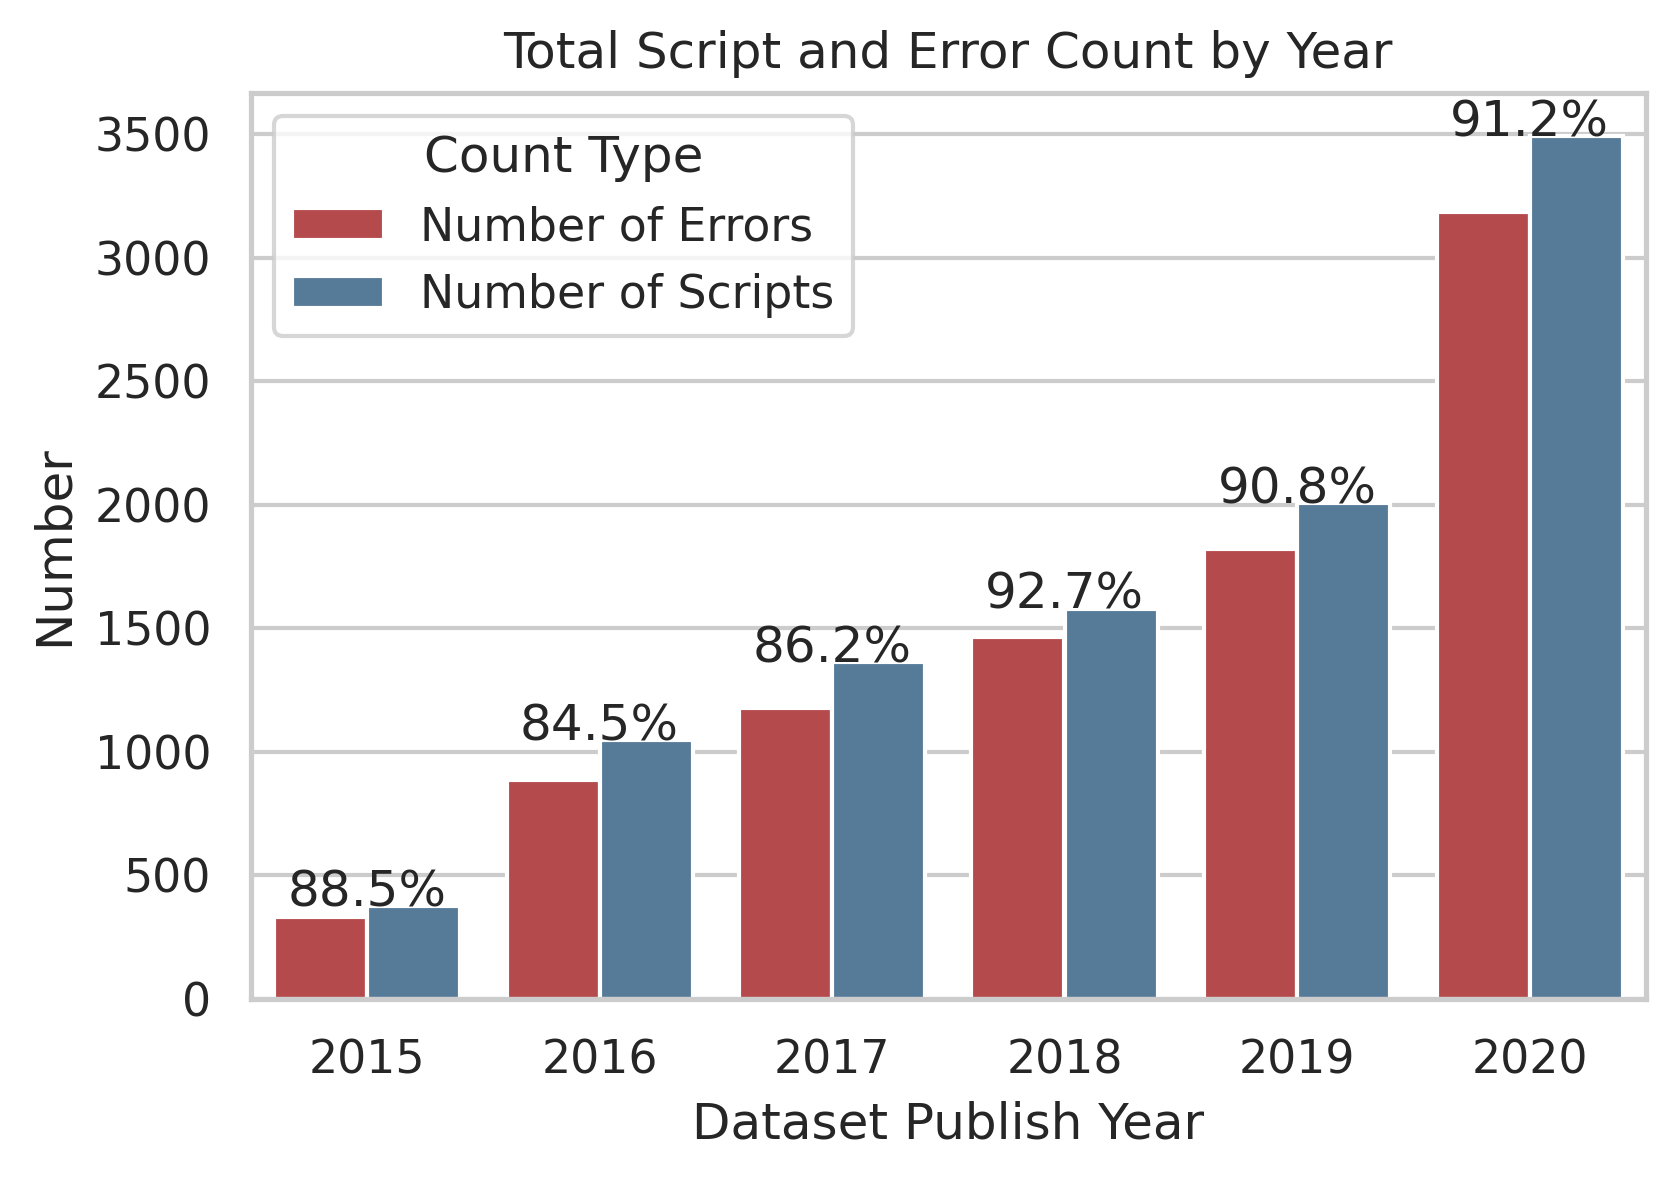

In [11]:
year_breakdown_df.columns = ["Year", "Number of Scripts", "Number of Errors", "Error Rate"]
year_melted_df = year_breakdown_df[["Year", "Number of Errors", "Number of Scripts"]]\
    .loc[year_breakdown_df['Year'].isin(["2015","2016", "2017", "2018", "2019", "2020"])]\
    .melt(id_vars='Year').rename(columns=str.title)
year_melted_df.columns = ["Year", "Count Type", "Count"]

#plt.figure(figsize=(10, 5), dpi=300)
plt.figure(dpi=300)
sns.set(color_codes=True)
sns.set_style("whitegrid")
sns.set_context("notebook")
ax = sns.barplot(x="Year", y="Count", hue="Count Type", data=year_melted_df, palette=sns.color_palette("Set1", n_colors=2, desat=.7))
ax.set_title('Total Script and Error Count by Year')
ax.set_xlabel("Dataset Publish Year")
ax.set_ylabel("Number")
year_errors_df = year_melted_df[year_melted_df["Count Type"] == "Number of Errors"]
x_index = 0
for index, row in year_errors_df.iterrows():
    x = row["Year"]
    y = row["Count"]
    total = year_melted_df[year_melted_df["Count Type"] == "Number of Scripts"]
    total = total[total["Year"] == row["Year"]]
    perc = round(row["Count"] / total["Count"].values[0] * 100, 1)
    ax.text(x=x_index,y=total["Count"].values[0],s=str(perc) + "%", ha="center")
    x_index += 1
#plt.show()
plt.savefig('../results/error_count_by_year.pdf', format="pdf")

### Breakdown by subject

In [12]:
subject_err_df = pd.DataFrame(columns=["Subject", "is_error"])

for _, row in subject_breakdown_df.iterrows():
    num_err = int(row["Total Error Files"])
    num_suc = int(row["Total Files"] - row["Total Error Files"])
    subject_err_df = subject_err_df.append(([pd.DataFrame({"Subject" : [row["Subject"]], "is_error": [0]})] * num_suc))
    subject_err_df = subject_err_df.append(([pd.DataFrame({"Subject" : [row["Subject"]], "is_error": [1]})] * num_err))
    

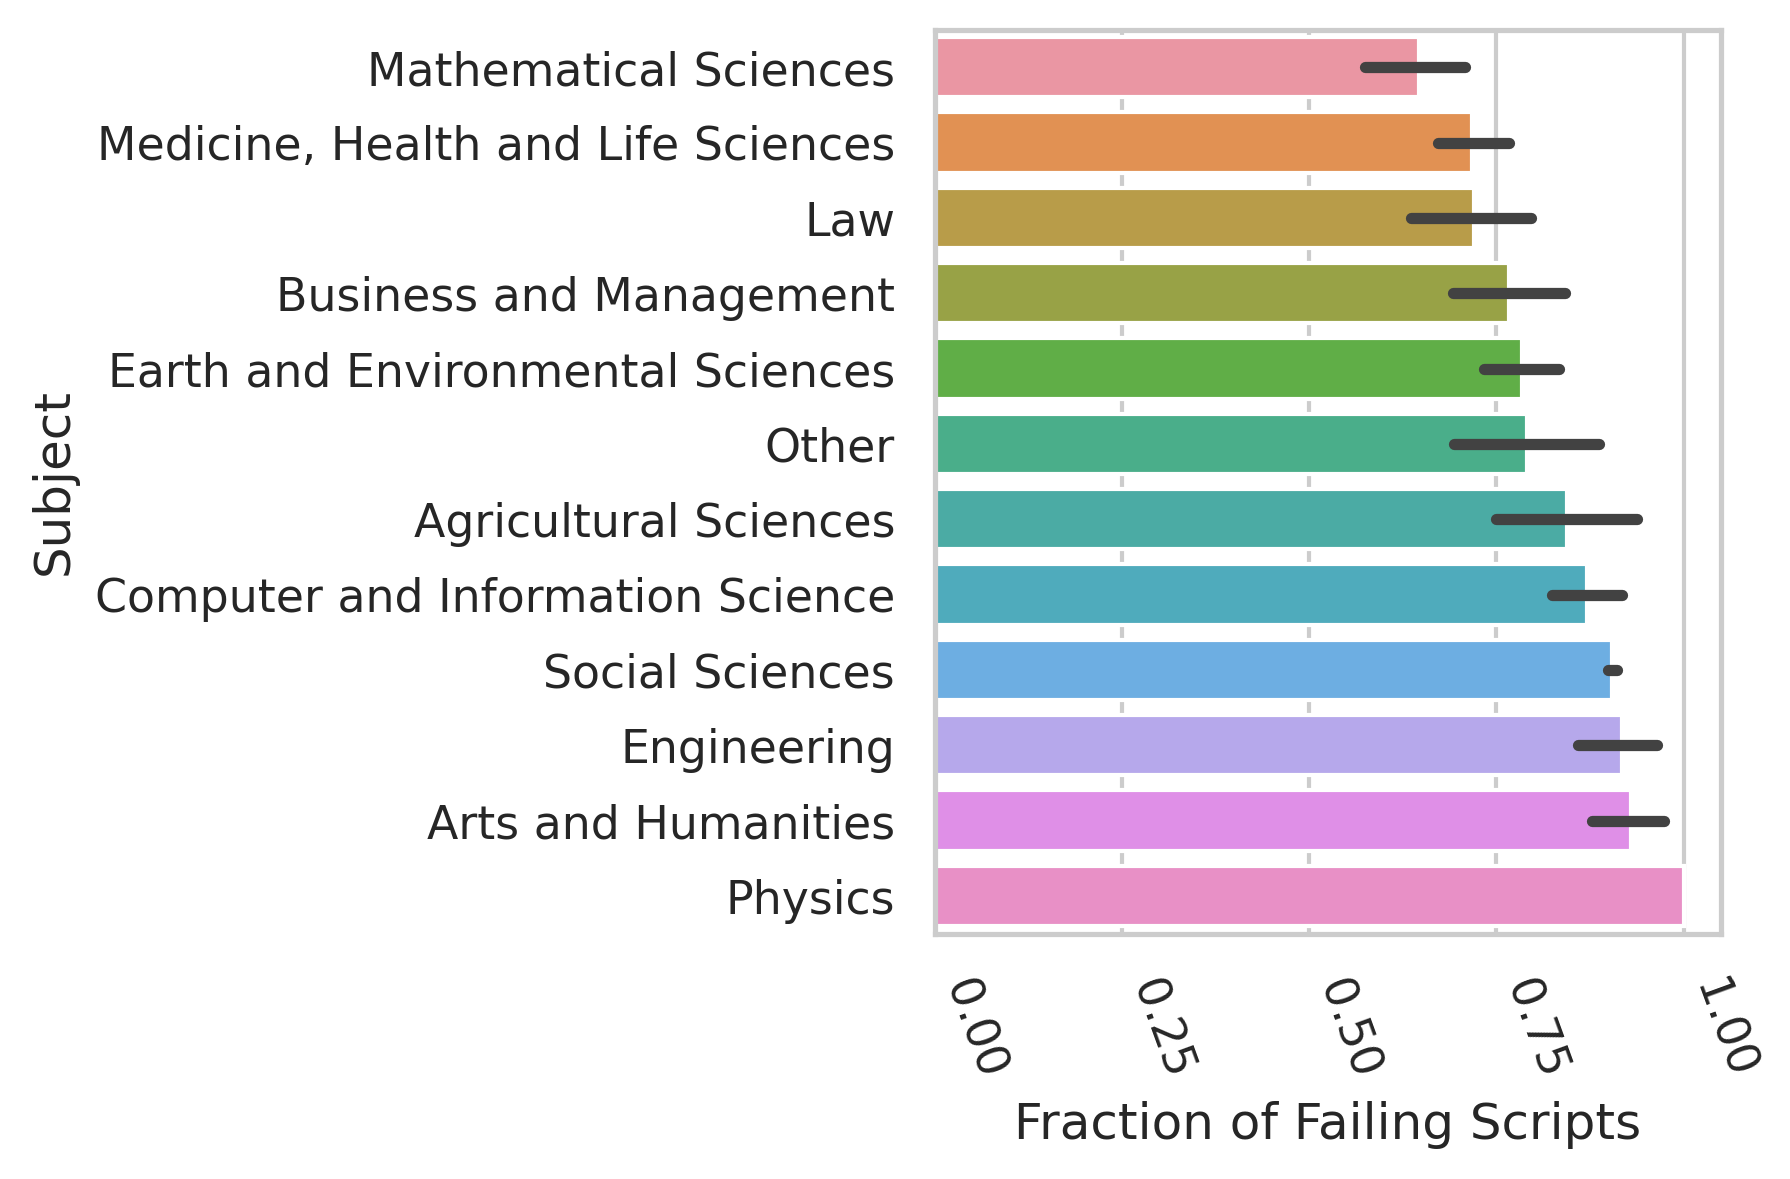

In [13]:
#plt.figure(figsize=(10, 7), dpi=300)
plt.figure( dpi=300)
plt.xticks(rotation=-70, ha = "left")
sns.set(color_codes=True)
sns.set_style("whitegrid")
sns.set_context("notebook")
ax = sns.barplot(y=subject_err_df['Subject'], 
                 x=subject_err_df['is_error'],
                order=["Mathematical Sciences", 
                      "Medicine, Health and Life Sciences",
                      "Law",
                      "Business and Management",
                      "Earth and Environmental Sciences",
                      "Other",
                      "Agricultural Sciences",
                      "Computer and Information Science",
                      "Social Sciences",
                      "Engineering",
                      "Arts and Humanities",
                      "Physics"])
#ax.set_title('Script Failure Proportion by Subject')
ax.set_ylabel("Subject")
ax.set_xlabel("Fraction of Failing Scripts")
plt.tight_layout()
#plt.gcf().subplots_adjust(bottom=0.5)
#plt.show()
plt.savefig('../results/error_rate_by_subject.pdf', format="pdf")

## Code used to generate tables displaying results of executing scripts WITH RaaS

### Merge databases 

We ran the evaluation in parallel so we have multiple databases that each contain the results from a range of dois. Each database is stored with the following filename format: startRange-endRange-app.db. 

The range indicates the dois processed; however, some datasets may have timed-out or failed. So, a range of 0-99 does not guarantee there will be 100 rows in a dataset.

In [3]:
# Collect the path to all databases that contain data for datasets evaluated by RaaS
db_files = [y for x in os.walk("../data/") for y in glob(os.path.join(x[0], '*app.db'))]

# List of dataframes to concat later from each database
result_dfs = []

# Convert the dataset table written by RaaS to a dataframe for each database we have and then 
# concat into a single dataframe we will use in the eval
for db_file in db_files:
    con = sqlite3.connect(db_file)
    result_dfs.append(pd.read_sql_query("SELECT * FROM dataset", con))

# The final dataframe that contains all of the data from all devices that processed datasets with RaaS
raas_df = pd.concat(result_dfs)

### Process data from RaaS

This cell will calculate total errors, total non-errors, and clean datasets, just like in the non-RaaS version. However, it will also determine on a script-by-script basis of the errors that existed when they were run with RaaS, what errors those scripts have now

In [12]:
# This dictionary holds initial results regarding errors in scripts 
def get_doi_from_tag_name(image_tag):
    return(image_tag[6:9] + image_tag[9:len(image_tag)].replace("-", ":", 1).upper().replace("-", "/"))
libraries = {}
raas_total_error_results ={"Errors" : 0, "No Errors": 0, "Clean Containers": 0}
raas_error_breakdown = {"library": 0, "working directory": 0, "missing file": 0, "function":0, "success":0, "other": 0}
error_change = {"library": {"library": 0, "working directory": 0, "missing file": 0, "function":0, "other": 0, "success" :0},
                "working directory": {"library": 0, "working directory": 0, "missing file": 0, "function":0, "other": 0, "success" :0},
                "missing file": {"library": 0, "working directory": 0, "missing file": 0, "function":0, "other": 0, "success" :0},
                "function":{"library": 0, "working directory": 0, "missing file": 0, "function":0, "other": 0, "success" :0},
                "other": {"library": 0, "working directory": 0, "missing file": 0, "function":0, "other": 0, "success" :0},
                "success": {"library": 0, "working directory": 0, "missing file": 0, "function":0, "other": 0, "success" :0}}


with open("../data/intermediate_raas_library_errors.tab", "w") as raas_library_file:
    raas_library_file.write("doi\tscript\terror\tlibrary\n")
    
with open("../data/intermediate_raas_wd_errors.tab", "w") as raas_wd_file:
    raas_wd_file.write("doi\tscript\terror\n")

for index, row in raas_df.iterrows():
    is_clean = False
    report = json.loads(row["report"])
    doi = get_doi_from_tag_name(report["Additional Information"]["Container Name"])
    print(doi)
    dataset_error_results = check_errors(report)
    raas_total_error_results["Errors"] += dataset_error_results["Errors"]
    raas_total_error_results["No Errors"] += dataset_error_results["No Errors"]
    if(dataset_error_results["Container-Wide"]):
        raas_total_error_results["Clean Containers"] += 1
        is_clean = True
    if(len(dataset_error_results["Error Causes"]) > 0):
        for error_tuple in dataset_error_results["Error Causes"]:
            '''
            if(error_tuple[0] != "success"):
                raas_error_breakdown[error_tuple[0]] += 1
            '''
            if(error_tuple[0] == "library"):
                with open("../data/intermediate_raas_library_errors.tab", "a") as raas_library_file:
                    row = doi + "\t" + error_tuple[1] + "\t" + error_tuple[2].strip("\n") + "\t" + library_name_from_error(error_tuple[2])
                    raas_library_file.write(row + "\n")
            if(error_tuple[0] == "working directory"):
                with open("../data/intermediate_raas_wd_errors.tab", "a") as raas_wd_file:
                    raas_wd_file.write(doi + "\t" + error_tuple[1] + "\t" + error_tuple[2])
            raas_error_breakdown[error_tuple[0]] += 1
            if(doi not in doi_library):
                doi_library[doi] = {}
            if("raas" not in doi_library[doi]):
                doi_library[doi]["raas"] = {}
  
            doi_library[doi]["raas"][error_tuple[1]] = error_tuple[0]
            if("no raas" in doi_library[doi] and error_tuple[1] in doi_library[doi]["no raas"]):
                previous_error = doi_library[doi]["no raas"][error_tuple[1]]
                error_change[previous_error][error_tuple[0]] += 1
                if(previous_error == "success" and error_tuple[0] != "success"):
                    pass
    
    if(doi not in doi_library):
        doi_library[doi] = {}
    doi_library[doi]["raas_build_time"] = report["Additional Information"]["Build Time"] 
    doi_library[doi]["report"] = report
    if(is_clean):
        doi_library[doi]["raas_clean"] = True
    else:
        doi_library[doi]["raas_clean"] = False
    for library in report["Container Information"]["Language Packages"]:
        if(library[0] in libraries.keys()):
            libraries[library[0]] += 1
        else:
            libraries[library[0]] = 1	
            
error_change_df = pd.DataFrame(error_change).transpose()

doi:10.7910/DVN/MB2UKU
doi:10.7910/DVN/JWL4PK
doi:10.7910/DVN/WQRZHS
doi:10.7910/DVN/DCTH7N
doi:10.7910/DVN/383K6K
doi:10.7910/DVN/96WYRS
doi:10.7910/DVN/SKGWTS
doi:10.7910/DVN/RZHL3X
doi:10.7910/DVN/5AJGH4
doi:10.7910/DVN/ZHGNOV
doi:10.7910/DVN/YAZVZE
doi:10.7910/DVN/1JNPUA
doi:10.7910/DVN/KPS1KY
doi:10.7910/DVN/Z02C8Y
doi:10.7910/DVN/YAIXFQ
doi:10.7910/DVN/TX160A
doi:10.7910/DVN/ZGPTNI
doi:10.7910/DVN/EMLHCT
doi:10.7910/DVN/OD5MBX
doi:10.7910/DVN/8CDVQ2
doi:10.7910/DVN/MUXIKE
doi:10.7910/DVN/BHKSZR
doi:10.7910/DVN/JLRL6P
doi:10.7910/DVN/YUM3K8
doi:10.7910/DVN/BE99YA
doi:10.7910/DVN/SG55BJ
doi:10.7910/DVN/NHKKE2
doi:10.7910/DVN/WWQSVD
doi:10.7910/DVN/AM3LJF
doi:10.7910/DVN/O0JVDU
doi:10.7910/DVN/ODQVVO
doi:10.7910/DVN/I8XQPM
doi:10.7910/DVN/P3HJGS
doi:10.7910/DVN/TT7NZJ
doi:10.7910/DVN/GCTLYJ
doi:10.7910/DVN/LPTJY1
doi:10.7910/DVN/DF4DFH
doi:10.7910/DVN/MB2DQA
doi:10.7910/DVN/KPAXSZ
doi:10.7910/DVN/EEMRS9
doi:10.7910/DVN/VLBOBH
doi:10.7910/DVN/VELJKG
doi:10.7910/DVN/QUPBSR
doi:10.7910

### View Results

This cell prints the results of the evaluation performed checking for errors without RaaS.

The publication presents this information in a table generated below.

In [13]:
raas_total_num_of_scripts = raas_total_error_results["Errors"] + raas_total_error_results["No Errors"]
print("Out of " + str(raas_total_num_of_scripts) + " total scripts")
print("Scripts without errors: " + str(raas_total_error_results['No Errors']) + ", or " + str((raas_total_error_results['No Errors'] / raas_total_num_of_scripts) * 100) + "% of total scripts")
print("Scripts with errors: " + str(raas_total_error_results['Errors']) + ", or " + str((raas_total_error_results['Errors'] / raas_total_num_of_scripts) * 100) + "% of total scripts")
print("Number of clean datasets: " + str(raas_total_error_results["Clean Containers"]) + " out of " + str(len(raas_df.index)))
print("##############################################################\n\n")
print("Error Breakdown: ")
print("Images created, one dataset per: " + str(raas_df.shape[0]))
print_error_breakdown("library",raas_error_breakdown, raas_total_error_results['Errors'])
print_error_breakdown("working directory",raas_error_breakdown, raas_total_error_results['Errors'])
print_error_breakdown("missing file",raas_error_breakdown, raas_total_error_results['Errors'])
print_error_breakdown("function",raas_error_breakdown, raas_total_error_results['Errors'])
print_error_breakdown("other",raas_error_breakdown, raas_total_error_results['Errors'])

Out of 134 total scripts
Scripts without errors: 62, or 46.26865671641791% of total scripts
Scripts with errors: 72, or 53.73134328358209% of total scripts
Number of clean datasets: 19 out of 45
##############################################################


Error Breakdown: 
Images created, one dataset per: 45
library errors: 5, or 6.944444444444445% of total errors
working directory errors: 0, or 0.0% of total errors
missing file errors: 28, or 38.88888888888889% of total errors
function errors: 3, or 4.166666666666666% of total errors
other errors: 36, or 50.0% of total errors


### Generate latex table

This cell will take the results computed previously and write the latex table used in the publication

In [17]:
raas_error_data = []
raas_error_occurence = {"Execution Results" : ["Success", "Error", "Total"], \
                        "Count" : [str(raas_total_error_results['No Errors']), str(raas_total_error_results['Errors']), str(raas_total_num_of_scripts)],  \
                       "Percentage (Rounded)" : [str(round((raas_total_error_results['No Errors'] / raas_total_num_of_scripts) * 100, 1)) + "%",  \
                       str(round((raas_total_error_results['Errors'] / raas_total_num_of_scripts) * 100, 1)) + "%", ""]}

for error_type in raas_error_breakdown.keys():
    raas_error_data.append({
        "Error Type": error_type.capitalize(), 
        "RaaS Count": str(raas_error_breakdown[error_type]), 
        "RaaS %": str(round((raas_error_breakdown[error_type] / raas_total_error_results['Errors']) * 100, 1)) + "%",
    })
     
raas_error_data.append({
    "Error Type": "Total Failures", 
    "RaaS Count": raas_total_error_results['Errors'], 
    "RaaS %": "",
})
raas_error_data_df = pd.DataFrame(raas_error_data, columns=["Error Type", "RaaS Count", "RaaS %"])

raas_error_data_df = raas_error_data_df[raas_error_data_df["Error Type"] != "Success"]

#raas_error_data_df["containR Count"] = ["8", "12", "1400", "NA", "62", "847", "2329"]
#raas_error_data_df["containR %"] = ["0.3%", "0.5%", "60.1%", "NA", "2.6%", "36.4%", ""]

raas_error_data_df["containR Count"] = ["8", "12", "1400", "NA", "847", "2329"]
raas_error_data_df["containR %"] = ["0.3%", "0.5%", "61.8%", "NA", "37.4%", ""]

raas_error_data_df = raas_error_data_df[["Error Type", "containR Count", "containR %", "RaaS Count", "RaaS %"]]

write_tex_from_df("raas_error_data.tex", raas_error_data_df, label= "tab:raas-error-data", \
                 caption = "The most common causes of errors in scripts from Dataverse after processing through RaaS compared to containR.")

write_tex_from_df("raas_error_occurence.tex", pd.DataFrame(raas_error_occurence), label = "tab:raas-err-occ", \
                 caption = "The occurrences of errors in scripts from Dataverse after processing through RaaS.")

In [18]:
write_tex_from_df("error_change.tex", error_change_df, index = True, label = "tab:error-change", \
                  caption = "How errors changed from running without RaaS, to running with RaaS. " + \
                  "The rows indicate errors occuring pre-RaaS. The columns are post-RaaS. " + \
                  "For example, 741 scripts encountered a library error pre-RaaS, but ran successfully post-RaaS.")

In [19]:
tidy_packs = []

with open("../data/tidyverse-packages.txt", "r") as tidy_txt:
    tidy_packs = tidy_txt.readlines()

tidy_packs = [pack.replace("\n", "") for pack in tidy_packs]

in_tidy = {}
not_tidy = {}

for package in broken_packages.keys():
    if package in tidy_packs:
        if(package in in_tidy):
            in_tidy[package] += broken_packages[package]
        else:
            in_tidy[package] = broken_packages[package]
    else:
        if(package in not_tidy):
            not_tidy[package] += broken_packages[package]
        else:
            not_tidy[package] = broken_packages[package]
            
print("Scripts that would fix an error using rocker/tidyverse: " + str(sum(in_tidy.values())))
print("Scripts that would not fix an error using rocker/tidyverse: " + str(sum(not_tidy.values())))
print("Unique packages fixed with tidyverse: " + str(len(in_tidy.keys())))
print("Unique packages not fixed with tidyverse: " + str(len(not_tidy.keys())))

packs_in_tidy_df = pd.DataFrame({"Unique Packages" : [len(in_tidy.keys()), len(not_tidy.keys())], "Total Scripts" : [sum(in_tidy.values()), sum(not_tidy.values())]}, \
             index = ["Preloaded In Tidyverse", "Not Preloaded"])

write_tex_from_df("packs_in_tidy.tex", packs_in_tidy_df, index=True, label = "tab:packs-in-tidy", \
                 caption = "This table shows how using the rocker/tidyverse container could potentially fix library errors from scripts since it contains commonly used packages. "\
                 + "In this table are the number of unique packages that Dataverse scripts fail to load, as well as the total number of scripts that attempt to load them.")

Scripts that would fix an error using rocker/tidyverse: 2234
Scripts that would not fix an error using rocker/tidyverse: 3236
Unique packages fixed with tidyverse: 43
Unique packages not fixed with tidyverse: 398


In [20]:
libraries

libraries_df = pd.DataFrame({"R Packages": list(libraries.keys()), "Times Package Used" : list(libraries.values())})
libraries_df = libraries_df.sort_values(by='Times Package Used', ascending = False)
libraries_df = libraries_df.reset_index()[["R Packages", "Times Package Used"]]

print(libraries_df)

times_libraries_used_df = libraries_df.groupby("Times Package Used").count()
times_libraries_used_df.columns = ["Count"]

#[times_libraries_used_df["Count"].select(0, 4),times_libraries_used_df["Count"].select(4, 26), times_libraries_used_df["Count"].select(26, 1843)] 
libraries_df.describe()

      R Packages  Times Package Used
0        foreign                1843
1           MASS                1828
2        lattice                1825
3       survival                1824
4           boot                1823
...          ...                 ...
1709    outliers                   1
1710  epiDisplay                   1
1711    sinaplot                   1
1712       infer                   1
1713         cna                   1

[1714 rows x 2 columns]


,Times Package Used
count,1714.000000
mean,227.079347
std,570.228242
min,1.000000
25%,1.000000
50%,4.000000
75%,26.000000
max,1843.000000


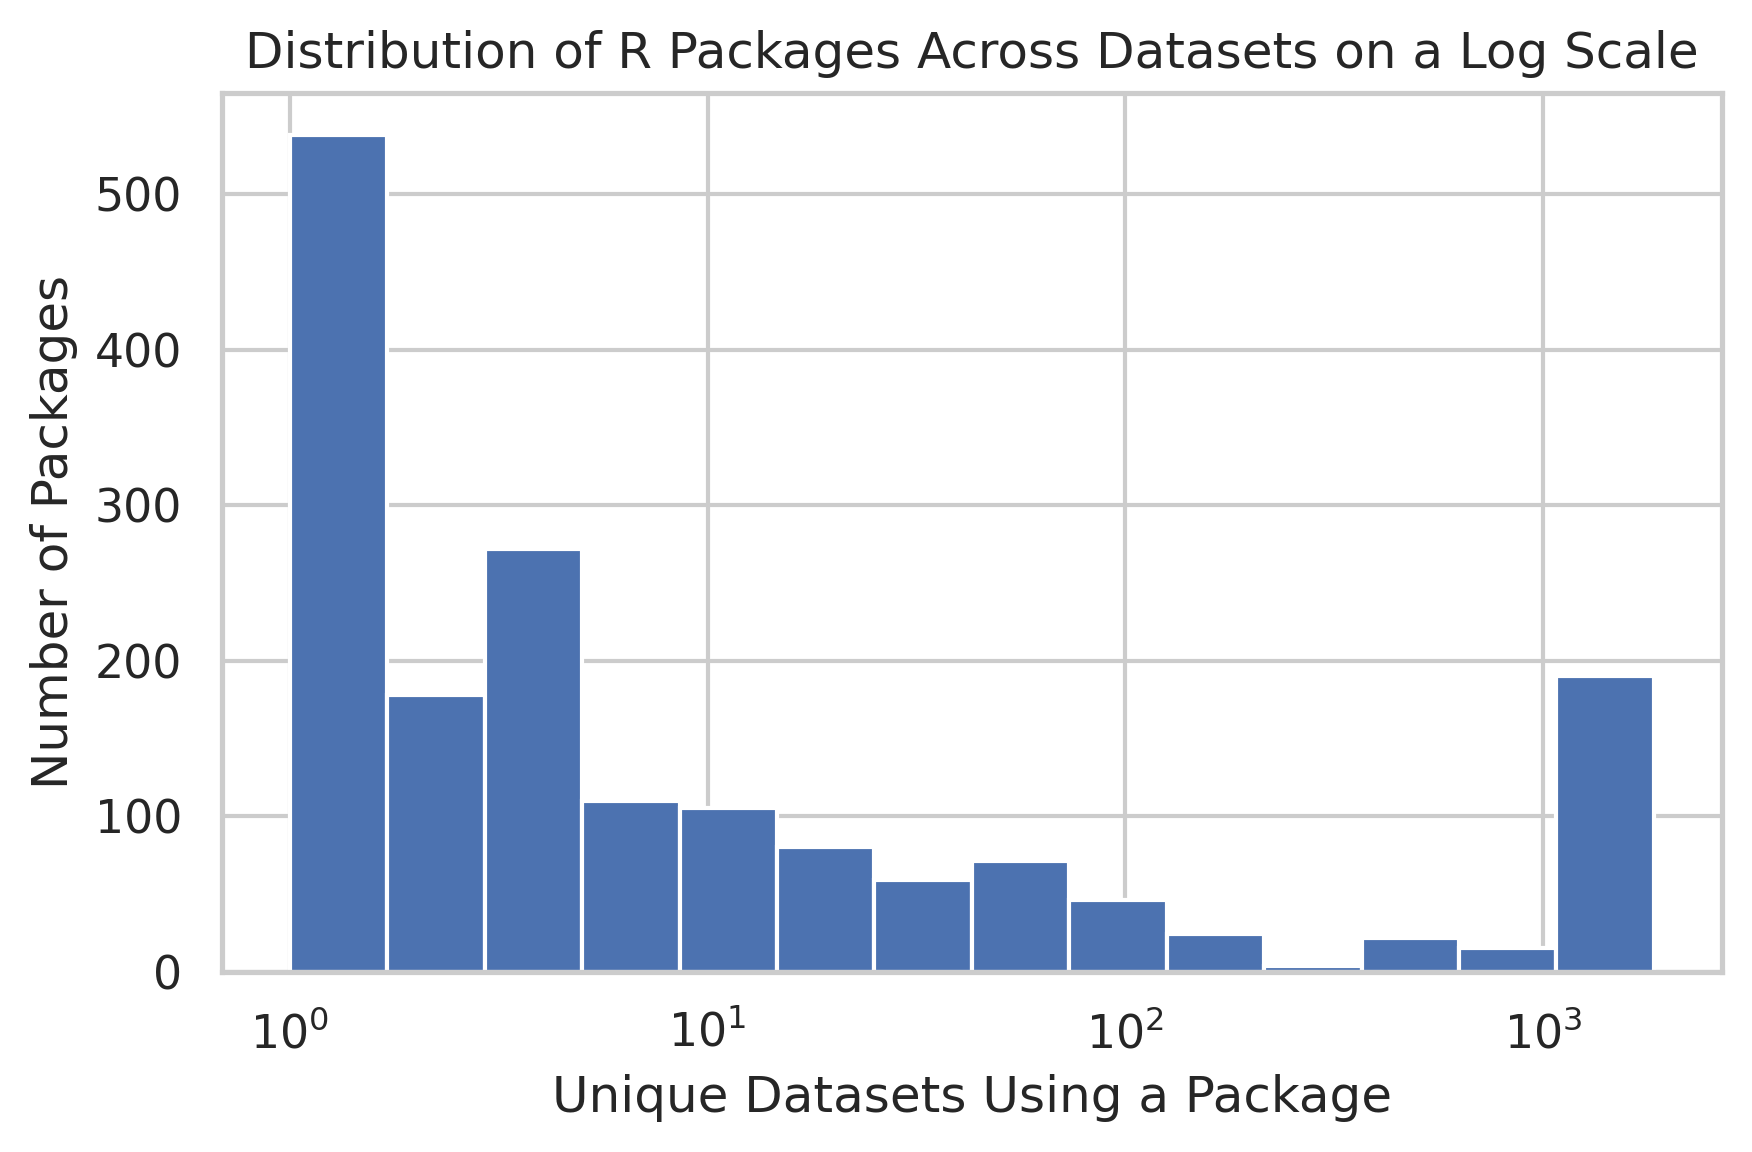

In [21]:
year_melted_df = year_breakdown_df[["Year", "Number of Errors", "Number of Scripts"]]\
    .loc[year_breakdown_df['Year'].isin(["2015", "2016", "2017", "2018", "2019", "2020", "2021"])]\
    .melt(id_vars='Year').rename(columns=str.title)
year_melted_df.columns = ["Year", "Count Type", "Count"]

#plt.figure(figsize=(10, 5), dpi=300)
plt.figure(dpi=300)
sns.set(color_codes=True)
sns.set_style("whitegrid")
sns.set_context("notebook")
#ax = sns.lineplot(x="Times Package Used", y="Count", data=times_libraries_used_df, palette=sns.color_palette("Set1", desat=.7))
ax = sns.histplot(x="Times Package Used", data=libraries_df, palette=sns.color_palette("Set1", desat=.7), alpha = 1,  stat= "count", log_scale = True)
#ax = sns.displot(x="Times Package Used", y="Count", data=times_libraries_used_df, palette=sns.color_palette("Set1", desat=.7), alpha = 1)
ax.set_title('Distribution of R Packages Across Datasets on a Log Scale')
ax.set_xlabel("Unique Datasets Using a Package")
ax.set_ylabel("Number of Packages")
plt.tight_layout()
plt.savefig('../results/package_distribution.pdf', format="pdf")

In [22]:
times_libraries_used_df

,Count
Times Package Used,
1,538
2,178
3,117
4,83
5,72
...,...
1823,2
1824,1
1825,1


In [23]:
full_dataset = {
    "No RaaS" : [str(round(no_raas_total_error_results["Clean Datasets"] / num_datasets * 100,1)) + "%"],
    "With RaaS" : [str(round(raas_total_error_results["Clean Containers"] / len(raas_df.index) * 100,1)) + "%"]
}

full_dataset

{'No RaaS': ['2.4%'], 'With RaaS': ['24.9%']}

In [24]:
complete_raas_time_out_noraas = 0
both_no_raas_total_count = 0
both_no_raas_error_count = 0
both_raas_total_count = 0
both_raas_error_count = 0
both_dataset_count = 0
both_raas_clean_dataset_count = 0
both_noraas_clean_dataset_count = 0
completed_noraas_to_raas_count = 0


for doi in doi_library:
    if("no_raas_clean" in doi_library[doi]):
        if(doi_library[doi]["no_raas_clean"] and "raas" not in doi_library[doi]):
            completed_noraas_to_raas_count += 1
    if("raas" in doi_library[doi] and "no raas" not in doi_library[doi]):
        complete_raas_time_out_noraas += 1
    if("raas" in doi_library[doi] and "no raas" in doi_library[doi]):
        both_dataset_count += 1
        clean_dataset = True
        for script in doi_library[doi]["no raas"]:
            both_no_raas_total_count += 1
            if(doi_library[doi]["no raas"][script] != "success"):
                both_no_raas_error_count += 1
                clean_dataset = False
        if(clean_dataset):
            both_noraas_clean_dataset_count +=1
        clean_dataset = True
        for script in doi_library[doi]["raas"]:
            both_raas_total_count += 1
            if(doi_library[doi]["raas"][script] != "success"):
                both_raas_error_count += 1
                clean_dataset = False
        if(clean_dataset):
            both_raas_clean_dataset_count +=1

        
comparison_dict = {
    "Without RaaS scripts":[str(both_no_raas_total_count), str(both_no_raas_total_count - both_no_raas_error_count), str(both_no_raas_error_count), \
                           str(round((both_no_raas_total_count - both_no_raas_error_count) / both_no_raas_total_count * 100, 1)) + "%"],
    "With RaaS scripts":[str(both_raas_total_count), str(both_raas_total_count - both_raas_error_count), str(both_raas_error_count), \
                        str(round((both_raas_total_count - both_raas_error_count) / both_raas_total_count  * 100, 1)) + "%"],
    "Without RaaS dsets" : [str(both_dataset_count), str(both_noraas_clean_dataset_count), str(both_dataset_count - both_noraas_clean_dataset_count), \
                           str(round(both_noraas_clean_dataset_count / both_dataset_count * 100, 1)) + "%"],
    "With RaaS dsets" : [str(both_dataset_count), str(both_raas_clean_dataset_count), str(both_dataset_count - both_raas_clean_dataset_count), \
                        str(round(both_raas_clean_dataset_count / both_dataset_count * 100, 1)) + "%"]
}

comparison_df = pd.DataFrame(comparison_dict)
comparison_df.index = ["Total", "Completed Successfully", "Completed With Error", "Percent Successful"]

write_tex_from_df("../results/pre-post-comp.tex",comparison_df, index=True, label="tab:pre-post", \
                  caption = "This table compares the execution results from scripts without RaaS compared to with RaaS. " + \
                  "This table contains only the scripts from datasets that completed under both conditions." + \
                 " The ``With RaaS'' category has fewer total scripts due to RaaS's preprocessing preventing sourced scripts from executing.")

completed_noraas_to_raas_count

15

In [25]:
raas_library_errors_df = pd.read_csv("../data/raas_library_errors.tab", sep ="\t")
library_names = list(raas_library_errors_df.library)

# library parses misses this one somehow
library_names.append("readme")

library_names = set(library_names)
library_names.remove("./")
library_names.remove("__UNDEFINED__")

len(library_names)

130

## RaaS Overhead

In [26]:
time_comparison = {"Without RaaS" : [], "With RaaS" : [], "Time Difference" : [], "Slowdown": []}


for doi in doi_library:
    if("raas_clean" not in doi_library[doi]):
        continue
    if("no_raas_clean" not in doi_library[doi]):
        continue    
    if(doi_library[doi]["no_raas_clean"] and doi_library[doi]["raas_clean"]):
        '''
        if(doi_library[doi]["raas_build_time"] < doi_library[doi]["no_raas_time"]):
            #print(doi_library[doi])
            continue
        '''
        time_comparison["Without RaaS"].append(doi_library[doi]["no_raas_time"])
        time_comparison["With RaaS"].append(doi_library[doi]["raas_build_time"])
        time_comparison["Time Difference"].append(doi_library[doi]["raas_build_time"] - doi_library[doi]["no_raas_time"])
        time_comparison["Slowdown"].append(round(doi_library[doi]["raas_build_time"] / doi_library[doi]["no_raas_time"], 1))
        if(doi_library[doi]["raas_build_time"] - doi_library[doi]["no_raas_time"] > 1000):
            print(doi_library[doi]["report"]["Individual Scripts"])

time_comparison_df = pd.DataFrame(time_comparison)


{'/home/rstudio/datasets/doi-10.7910-DVN-XWMSHO/datasets/CodData_FisherExact.R': {'Input Files': ['CodDataReleases.csv', 'CodDataRecoveries.csv'], 'Output Files': [], 'Warnings': [], 'Errors': []}}
{'/home/rstudio/datasets/doi-10.7910-DVN-GS3IKP/datasets/3wayindep.R': {'Input Files': [], 'Output Files': [], 'Warnings': [], 'Errors': []}, '/home/rstudio/datasets/doi-10.7910-DVN-GS3IKP/datasets/rutilities.R': {'Input Files': [], 'Output Files': [], 'Warnings': ['In  library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE,  :  there is no package called ‘plotfix’'], 'Errors': []}}


In [27]:
time_comparison_df["Slowdown"].describe()

count    45.000000
mean      9.551111
std      17.832333
min       0.200000
25%       2.700000
50%       4.000000
75%       7.200000
max      98.300000
Name: Slowdown, dtype: float64

In [28]:
abnormal_time = time_comparison_df[time_comparison_df["Time Difference"] < 0]
abnormal_time.to_csv("../results/abnormal_times.csv")

count      45.000000
mean      130.619464
std       286.634710
min      -295.617187
25%        36.813241
50%        47.008151
75%        72.867091
max      1351.105481
Name: Time Difference, dtype: float64

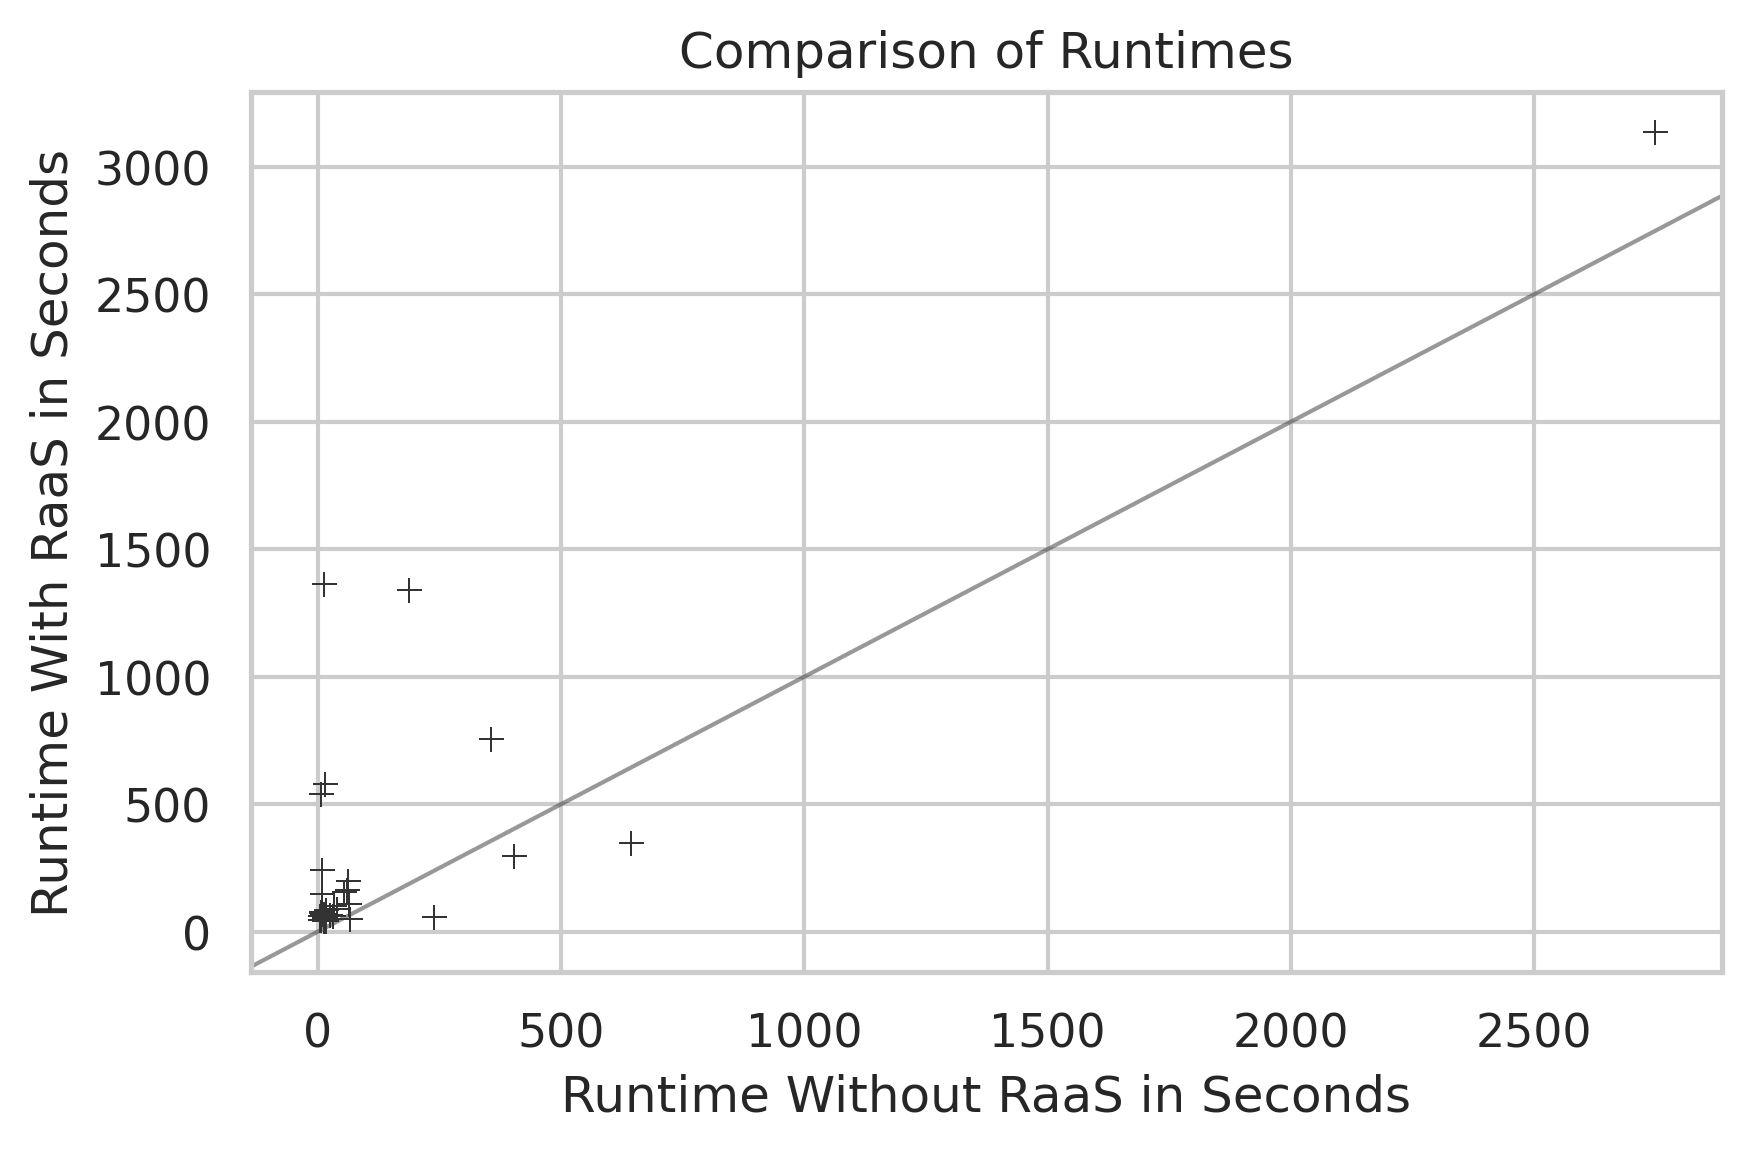

In [29]:
#plt.figure(figsize=(10, 5), dpi=300)
plt.figure(dpi=300)
sns.set(color_codes=True)
sns.set_style("whitegrid")
sns.set_context("notebook")
ax = sns.scatterplot(x="Without RaaS", y="With RaaS", data=time_comparison_df, color = ".2", marker ="+")
ax.set_title('Comparison of Runtimes')
ax.set_xlabel("Runtime Without RaaS in Seconds")
ax.set_ylabel("Runtime With RaaS in Seconds")
plt.tight_layout()
ax.axline([0, 0], [1, 1], linewidth=1, alpha = 0.5, color = "0.2")
#plt.show()
plt.savefig('../results/runtime-comparison.pdf', format="pdf")

In [30]:
timeout_dict = {
    "Total Datasets":["2900", "100%"],
    "TO w/o RaaS" : [str(2900 - num_datasets), str(round((2900 - num_datasets) / 2900 * 100 , 1)) + "%"],
    "TO w/ RaaS" : [str(2900 - len(raas_df.index)), str(round((2900 - len(raas_df.index)) / 2900 * 100, 1)) + "%"],
    "Both Completed" : [str(2900 - both_dataset_count), str(round((2900 - both_dataset_count) / 2900 * 100 , 1)) + "%"],
    "# Scripts in Both" : [str(both_no_raas_total_count), str(round((11819 - both_no_raas_total_count) / 11819 * 100, 1)) + "%*"]
}

timeout_df = pd.DataFrame(timeout_dict)

write_tex_from_df("../results/timeout-results.tex", timeout_df, label="tab:timeout-results", caption = \
                 "This table displays the number of datasets that time out (TO) during the evaluations, and the number that completed with and without RaaS. " + \
                 "*Note that for the number of scripts that completed in both, the percentage is out of the total number of scripts: 11819. " + \
                 "The rest of the percentages are out of the total number of datasets: 2900.")

In [31]:
time_comparison_df

,Without RaaS,With RaaS,Time Difference,Slowdown
0,67.163282,51.023566,-16.139717,0.8
1,6.469561,79.336651,72.867091,12.3
2,7.984754,146.782941,138.798187,18.4
3,644.844687,349.227500,-295.617187,0.5
4,3.975423,59.922604,55.947181,15.1
5,15.667221,579.358614,563.691393,37.0
6,7.897656,541.435097,533.537441,68.6
7,7.066500,46.912641,39.846141,6.6
8,7.047690,44.868172,37.820482,6.4
9,5.489458,46.513037,41.023579,8.5


In [35]:
num_successful_sourced = 0

for doi in doi_library:
    if('raas' in doi_library[doi] and 'no raas' in doi_library[doi]):
        for script in doi_library[doi]['no raas']:
            if(script not in doi_library[doi]['raas'] and doi_library[doi]["no raas"][script] == "success"):
                num_successful_sourced += 1
                
num_successful_sourced

299

In [48]:
# Number of scripts that were successful without RaaS, but were in a dataset that timed out with RaaS
to_raas_noto_no_raas_successes = 0
total_scripts_to = 0
num_of_scripts_to = []

for doi in doi_library:
    if('raas' not in doi_library[doi] and 'no raas' in doi_library[doi]):
        num_of_scripts_to.append(len(doi_library[doi]['no raas']))
        for script in doi_library[doi]['no raas']:
            total_scripts_to += 1
            if(doi_library[doi]["no raas"][script] == "success"):
                to_raas_noto_no_raas_successes += 1


print("Number of scripts that were successful without RaaS, but were in a dataset that timed out with RaaS: " + str(to_raas_noto_no_raas_successes))
print("Out of all the scripts that were part of datasets that timed out with RaaS: " + str(total_scripts_to))

max(num_of_scripts_to)


Number of scripts that were successful without RaaS, but were in a dataset that timed out with RaaS: 344
Out of all the scripts that were part of datasets that timed out with RaaS: 4341


74